# Problema

Queremos predizer se um cliente de uma compania aerea gostou de seu voou, com base nas seguintes caracteristicas

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
from copy import copy
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import f1_score
from sklearn import ensemble
from sklearn import svm

# Importando dataset

In [16]:
df = pd.read_csv('../datasets/airline_passenger_satisfaction.csv').drop('ID',axis=1)

# Analidando os dados

vemos que apenas a feature Arrival Delay possui valores nulos e possui um alta correlação com outra coluna, optei por remove-lá

In [17]:
df.drop('Arrival Delay', axis=1, inplace=True)

# Separando features e labels

In [18]:
X = df.iloc[:10000,:-1]
y = df['Satisfaction'].values[:10000]

# Discretizando o label

In [19]:
y = OrdinalEncoder().fit_transform(y.reshape(-1,1)).ravel()

# Separando treino e teste

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8,random_state=42,stratify=y)

# Inicializando ColumnTransformer para features sem e com escalonamento

In [21]:
pre = ColumnTransformer(transformers=[
  ('cat', OneHotEncoder(sparse=False), ['Gender','Customer Type','Type of Travel','Class'])
], remainder= 'passthrough')

In [22]:
pre_esc = ColumnTransformer(transformers=[
  ('cat', OneHotEncoder(sparse=False), ['Gender','Customer Type','Type of Travel','Class']),
  ('num', StandardScaler(), [x for x in range(21) if x not in [0,2,3,4]])
])

# Incializandao modelos

In [23]:
pred_models = {
    'rf': ensemble.RandomForestClassifier(n_jobs=-1, random_state=42),
    'gb': ensemble.GradientBoostingClassifier(random_state=42),
    'svm': svm.SVC(random_state=42),
}

# Dicionarios que receberão o resultado dos testes

In [24]:
res_train = {}
res_test = {}
res_esc_train = {}
res_esc_test = {}

# Sem escalonamento

In [25]:
for k,m in pred_models.items():
  pipe = Pipeline(steps=[
    ('pre', copy(pre)),
    ('est', copy(m))
  ])
  
  if k == 'rf':
    param_grid = {
      'est__n_estimators': [80,100,120,130,140],
      'est__max_depth': [None,20,50],
      'est__min_samples_split': [2,3,4],
      'est__min_samples_leaf': [1,2,3]}
  
  elif k == 'gb':
    param_grid = {
      'est__learning_rate': [0.05,0.1,0.15,0.2],
      'est__n_estimators': [100,130,140,150],
      'est__max_depth': [2,5,8,10]}
  
  else:
    param_grid = {
      'est__C': [0.1, 1, 10, 100, 1000],
      'est__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
      'est__kernel': ['rbf']}

  grid_search = GridSearchCV(pipe, param_grid, scoring='f1',cv=3, n_jobs=-1)
  
  grid_search.fit(X_train, y_train)

  best_pa = grid_search.best_params_
  y_pred_train = grid_search.predict(X_train)
  y_pred_test = grid_search.predict(X_test)
  train_score = f1_score(y_train, y_pred_train)
  test_score = f1_score(y_test, y_pred_test)

  res_train[k] = train_score
  res_test[k] = test_score

  print(k)
  print(best_pa)
  print(train_score)
  print(test_score)

rf
{'est__max_depth': None, 'est__min_samples_leaf': 1, 'est__min_samples_split': 2, 'est__n_estimators': 120}
1.0
0.9569321533923303
gb
{'est__learning_rate': 0.15, 'est__max_depth': 8, 'est__n_estimators': 100}
1.0
0.9606114050558496
svm
{'est__C': 100, 'est__gamma': 0.0001, 'est__kernel': 'rbf'}
0.9127055306427505
0.8467595396729255


# Com escalonamento

In [26]:
for k,m in pred_models.items():
  pipe = Pipeline(steps=[
    ('pre', copy(pre_esc)),
    ('est', copy(m))
  ])
  
  if k == 'rf':
    param_grid = {
      'est__n_estimators': [80,100,120,130,140],
      'est__max_depth': [None,20,50],
      'est__min_samples_split': [2,3,4],
      'est__min_samples_leaf': [1,2,3]}
  
  elif k == 'gb':
    param_grid = {
      'est__learning_rate': [0.05,0.1,0.15,0.2],
      'est__n_estimators': [100,130,140,150],
      'est__max_depth': [2,5,8,10]}
  
  else:
    param_grid = {
      'est__C': [0.1, 1, 10, 100, 1000],
      'est__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
      'est__kernel': ['rbf']}

  grid_search = GridSearchCV(pipe, param_grid, scoring='f1',cv=3, n_jobs=-1)
  
  grid_search.fit(X_train, y_train)

  best_pa = grid_search.best_params_
  y_pred_train = grid_search.predict(X_train)
  y_pred_test = grid_search.predict(X_test)
  train_score = f1_score(y_train, y_pred_train)
  test_score = f1_score(y_test, y_pred_test)

  res_esc_train[k] = train_score
  res_esc_test[k] = test_score

  print(k)
  print(best_pa)
  print(train_score)
  print(test_score)

rf
{'est__max_depth': None, 'est__min_samples_leaf': 1, 'est__min_samples_split': 4, 'est__n_estimators': 120}
0.99767644496079
0.9574970484061393
gb
{'est__learning_rate': 0.15, 'est__max_depth': 8, 'est__n_estimators': 100}
1.0
0.9611764705882354
svm
{'est__C': 100, 'est__gamma': 0.01, 'est__kernel': 'rbf'}
0.969165570656145
0.9519343493552169


In [27]:
res_train_df = pd.DataFrame.from_dict(res_train, orient='index', columns=['treino sem escalonamento'])
res_test_df = pd.DataFrame.from_dict(res_test, orient='index', columns=['teste sem escalonamento'])
res_esc_train_df = pd.DataFrame.from_dict(res_esc_test, orient='index', columns=['treino escalonado'])
res_esc_test_df = pd.DataFrame.from_dict(res_esc_test, orient='index', columns=['teste escalonado'])
df_res = pd.concat([res_train_df,res_test_df,res_esc_train_df,res_esc_test_df], axis=1)

In [28]:
df_res

,treino sem escalonamento,teste sem escalonamento,treino escalonado,teste escalonado
rf,1.000000,0.956932,0.957497,0.957497
gb,1.000000,0.960611,0.961176,0.961176
svm,0.912706,0.846760,0.951934,0.951934


<AxesSubplot:>

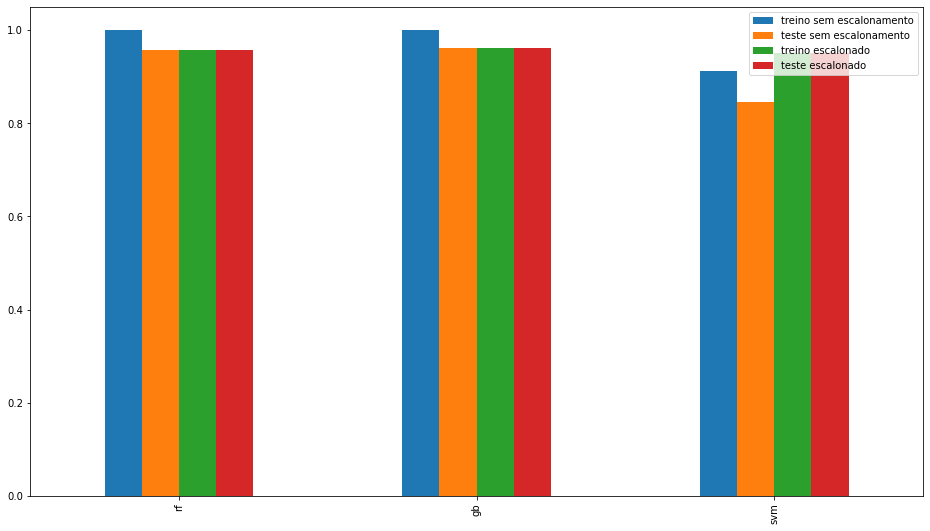

In [29]:
df_res.plot(kind='bar', figsize=(16,9))